In [132]:
import logging
L = logging.getLogger(__name__)
from pathlib import Path

import pandas as pd
import seaborn as sns

In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../..")
from berp.datasets.alignment import Aligner

In [3]:
presentation_words_path = "/home/jgauthie/om2/others/heilbron2022/notebooks/exported/words.csv"
presentation_phonemes_path = "/home/jgauthie/om2/others/heilbron2022/notebooks/exported/phonemes.csv"
tokenized_path = "oms.txt"

story_name = "oms"
output_dir = "."

In [19]:
tokens = Path(tokenized_path).read_text().split(" ")

In [118]:
words_df = pd.read_csv(presentation_words_path, index_col=[0, 1]).rename_axis(["run", "word_idx"])
phonemes_df = pd.read_csv(presentation_phonemes_path, index_col=[0, 1])

In [119]:
# # Collapse over runs.
# # TODO we need data about the lengths of runs here -- this is inaccurate!
# words_df.droplevel(1).reset_index().rename_axis("word_idx")
words_df

word   onset  offset
run word_idx                         
1   0              HE    0.76    0.88
    1             WAS    0.88    1.04
    2              AN    1.04    1.12
    3             OLD    1.12    1.41
    4             MAN    1.41    1.79
...               ...     ...     ...
19  585        LOOKED  175.41  175.66
    586            AT  175.66  175.81
    587            IT  175.81  175.92
    588            IN  175.92  176.04
    589       DISGUST  176.04  176.67

[10771 rows x 3 columns]

In [120]:
phonemes_df

phoneme    onset   offset
run                               
1   0          h    0.766    0.805
    1          i    0.812    0.875
    2          w    0.883    0.953
    3          ʌ    0.961    0.984
    4          z    0.992    1.031
...          ...      ...      ...
19  1826       s  176.141  176.234
    1827       g  176.242  176.312
    1828       ʌ  176.320  176.438
    1829       s  176.445  176.555
    1830       t  176.562  176.664

[33746 rows x 3 columns]

## Prepare phoneme data

In [121]:
# Asof merge: join phonemes to most recent corresponding word onset.
def merge_asof_by_run(run_phonemes):
    ret = pd.merge_asof(run_phonemes, words_df.loc[run_phonemes.name, ["onset", "offset", "word"]].reset_index(),
                        on="onset", direction="backward", suffixes=("", "_word"))
    
    # Find phonemes who exceed word boundaries. These are annotation mistakes (or bugs in our merge code :)
    phonemes_to_drop = ret.onset >= ret.offset_word
    L.warning(f"{phonemes_to_drop.sum()} are missing a word annotation -- likely their containing word has an onset which comes later than the onset of this phoneme.")
    
    ret = ret[~phonemes_to_drop]
    L.info(f"{len(ret)} phonemes remain.")
    
    return ret

phonemes_df = phonemes_df.groupby("run").apply(merge_asof_by_run).rename_axis(["run", "phoneme_idx"])
phonemes_df

4 are missing a word annotation -- likely their containing word has an onset which comes later than the onset of this phoneme.
5 are missing a word annotation -- likely their containing word has an onset which comes later than the onset of this phoneme.
5 are missing a word annotation -- likely their containing word has an onset which comes later than the onset of this phoneme.
6 are missing a word annotation -- likely their containing word has an onset which comes later than the onset of this phoneme.
5 are missing a word annotation -- likely their containing word has an onset which comes later than the onset of this phoneme.
8 are missing a word annotation -- likely their containing word has an onset which comes later than the onset of this phoneme.
4 are missing a word annotation -- likely their containing word has an onset which comes later than the onset of this phoneme.
3 are missing a word annotation -- likely their containing word has an onset which comes later than the onset o

phoneme    onset   offset  word_idx  offset_word     word
run phoneme_idx                                                          
1   0                 h    0.766    0.805         0         0.88       HE
    1                 i    0.812    0.875         0         0.88       HE
    2                 w    0.883    0.953         1         1.04      WAS
    3                 ʌ    0.961    0.984         1         1.04      WAS
    4                 z    0.992    1.031         1         1.04      WAS
...                 ...      ...      ...       ...          ...      ...
19  1826              s  176.141  176.234       589       176.67  DISGUST
    1827              g  176.242  176.312       589       176.67  DISGUST
    1828              ʌ  176.320  176.438       589       176.67  DISGUST
    1829              s  176.445  176.555       589       176.67  DISGUST
    1830              t  176.562  176.664       589       176.67  DISGUST

[33633 rows x 6 columns]

## Align words and tokens

In [122]:
# Hacks
assert words_df.loc[5].loc[446].word == "J."
words_df.loc[5].loc[446, "word"] = "J"

In [123]:
alignment = Aligner(tokens, words_df, max_skip_patience=0)()

he -- he
was -- was
an -- an
old -- old
man -- man
who -- who
fished -- f
fished -- ished
alone -- alone
in -- in
a -- a
skiff -- sk
skiff -- iff
in -- in
the -- the
gulf -- gulf
stream -- stream
and -- and
he -- he
had -- had
gone -- gone
eighty -- eighty
four -- four
days -- days
now -- now
without -- without
taking -- taking
a -- a
fish -- fish
in -- in
the -- the
first -- first
forty -- forty
days -- days
a -- a
boy -- boy
had -- had
been -- been
with -- with
him -- him
but -- but
after -- after
forty -- forty
days -- days
without -- without
a -- a
fish -- fish
the -- the
boy's -- boy
boy's -- 's
parents -- parents
had -- had
told -- told
him -- him
that -- that
the -- the
old -- old
man -- man
was -- was
now -- now
definitely -- definitely
and -- and
finally -- finally
salao -- sal
salao -- ao
which -- which
is -- is
the -- the
worst -- worst
form -- form
of -- of
unlucky -- unlucky
and -- and
the -- the
boy -- boy
had -- had
gone -- gone
at -- at
their -- their
orders -- orders
i

In [124]:
alignment = pd.DataFrame([token for _, token, _ in alignment],
    columns=["token_idx"],
    index=pd.MultiIndex.from_tuples([idx for idx, _, _ in alignment],
                                 names=words_df.index.names))
alignment

token_idx
run word_idx           
1   0                 0
    1                 1
    2                 2
    3                 3
    4                 4
...                 ...
19  585           12671
    586           12672
    587           12673
    588           12674
    589           12675

[11289 rows x 1 columns]

In [125]:
# NB inner join -- will duplicate word rows if there are multiple corresponding tokens.
words_df = pd.merge(words_df, alignment, left_index=True, right_index=True)
assert len(words_df) == len(alignment)
words_df

word   onset  offset  token_idx
run word_idx                                    
1   0              HE    0.76    0.88          0
    1             WAS    0.88    1.04          1
    2              AN    1.04    1.12          2
    3             OLD    1.12    1.41          3
    4             MAN    1.41    1.79          4
...               ...     ...     ...        ...
19  585        LOOKED  175.41  175.66      12671
    586            AT  175.66  175.81      12672
    587            IT  175.81  175.92      12673
    588            IN  175.92  176.04      12674
    589       DISGUST  176.04  176.67      12675

[11289 rows x 4 columns]

In [129]:
phonemes_df

phoneme    onset   offset  word_idx  offset_word     word
run phoneme_idx                                                          
1   0                 h    0.766    0.805         0         0.88       HE
    1                 i    0.812    0.875         0         0.88       HE
    2                 w    0.883    0.953         1         1.04      WAS
    3                 ʌ    0.961    0.984         1         1.04      WAS
    4                 z    0.992    1.031         1         1.04      WAS
...                 ...      ...      ...       ...          ...      ...
19  1826              s  176.141  176.234       589       176.67  DISGUST
    1827              g  176.242  176.312       589       176.67  DISGUST
    1828              ʌ  176.320  176.438       589       176.67  DISGUST
    1829              s  176.445  176.555       589       176.67  DISGUST
    1830              t  176.562  176.664       589       176.67  DISGUST

[33633 rows x 6 columns]

<AxesSubplot:ylabel='Count'>

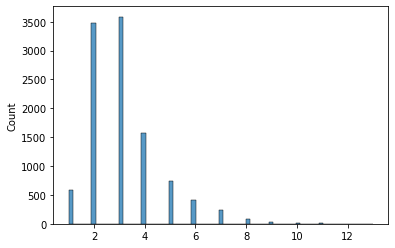

In [134]:
# Verify there is a reasonable word length distribution.
sns.histplot(phonemes_df.groupby(["run", "word_idx"]).size())

In [148]:
# Remove words with missing phoneme data.
covered_words = set(list(phonemes_df.reset_index()[["run", "word_idx"]].itertuples(index=False)))
missing_words = [f for f in words_df.index if f not in covered_words]
if len(missing_words) > 0:
    L.warning(f"{len(missing_words)} words without any associated phoneme data. Dropping these annotations.")
    words_df = words_df.drop(index=missing_words)

34 words without any associated phoneme data. Dropping these annotations.


In [150]:
words_df.to_csv(Path(output_dir) / "word.csv")
phonemes_df.to_csv(Path(output_dir) / "phoneme.csv")